In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

%matplotlib inline

import re
plt.style.use('dark_background')
# plt.style.use('ggplot')

In [263]:
pre_merged = pd.read_csv('./Unmerged Data/Pre_Merged_Data.csv', encoding='latin-1')
crime = pd.read_csv('./Unmerged Data/Other Data/CrimeOneYearofData.csv', encoding='latin-1')
exp_per_pupil = pd.read_csv('C:\\Users\\Mark\\GA\\Projects\\project-3\\Unmerged Data\\School Data\\expenditure_per_pupil_SS1300A18.dat', sep='|', encoding='latin-1')

# rename stat column for merging and capatilize state name
crime.rename(columns={'State':'state_crime'}, inplace=True)

crime['state_crime'] = crime['state_crime'].str.upper()

# expense per pupil renaming columns and removing blank columns
per_pupil_renamed    = ['geotype', 'st', 'geo_id', 'geo_ttl', 'year', 'enroll_per_pupil', 'total_expnd_per_pupil',
                        'objects_salary_wage_per_pupil', 'objects_employee_benefits_per_pupil',
                        'instruction_total_per_pupil', 'instruction_salary_wages_per_pupil', 
                        'instruction_employee_benefits_per_pupil', 'suport_services_total_per_pupil', 
                        'pupil_support_per_pupil', 'instruction_staff_support_per_pupil', 
                        'services_general_admin_per_pupil', 'services_school_admin_per_pupil']

exp_per_pupil = exp_per_pupil.dropna(axis=1)

exp_per_pupil.columns = per_pupil_renamed

In [264]:
df_names = [pre_merged, crime]
for i in df_names:
    i.rename(columns= {col: col.lower() for col in i.columns}, inplace=True)

In [265]:
def rate_cleaner2(i):
    try:
        left , right = i.split('-')
        return round((int(left)+int(right))/2)
        
    except:
        if pd.isnull(i):
            return np.nan
        
        if i[0] == 'L':
            return round(int(i[2:])/2)
            
        if i[0] == 'G':
            return round((int(i[2:]) + 100) / 2)

        if i == 'PS':
            return np.nan
        
        if i.isnumeric():
            return int(i)
        
def money_cleaner(cell):    
    if pd.isnull(cell):
        return int('0')
    else:
        return int(cell.replace(',' , '').strip('$'))

In [266]:
list_columns = [i for i in pre_merged.columns[7:24] if 'rate' in i]
for i in list_columns:
    pre_merged[i] = pre_merged[i].apply(rate_cleaner2)

money_col = ['med_hhd_inc_acs_08_12', 'med_hhd_inc_acsmoe_08_12', 'aggregate_hh_inc_acs_08_12', 'aggregate_hh_inc_acsmoe_08_12', 'med_house_value_acs_08_12',
     'med_house_value_acsmoe_08_12', 'aggr_house_value_acs_08_12', 'aggr_house_value_acsmoe_08_12']
for i in money_col:
    pre_merged[i] = pre_merged[i].apply(money_cleaner)

In [267]:
# Calcualte Percentage of students that are economically disadvantaged
pre_merged['Econ_Disadv_Percent'] = pre_merged['ecd_cohort_1112'] / pre_merged['all_cohort_1112']

## Mergeing Crime and Expenses

In [268]:
school_id_per_pupil = []
for i in exp_per_pupil['geo_id']:
    school_id_per_pupil.append(int(i.split('US')[1]))

exp_per_pupil['leaid'] = school_id_per_pupil

In [269]:
merged_df = pd.merge(pre_merged, exp_per_pupil[['leaid', 'instruction_salary_wages_per_pupil']], how='left', left_on='leaid11', right_on='leaid').drop('leaid', axis=1)

In [270]:
merged_df = pd.merge(merged_df, crime[['state_crime', 'population', 'violent crime total', 'property crime total', 'violent crime rate', 'property crime rate']],
         how='left', left_on='stnam', right_on='state_crime').drop('state_crime', axis=1)

## Model Prep

In [271]:
merged_df = merged_df.rename(columns={
    'pct_othr_lang_acs_08_12': 'English_Second_Lang',
    'pct_age5p_only_eng_acs_08_12': 'English_Primary',
    'med_hhd_inc_acs_08_12': 'Median_HH_Income',
    'pct_prs_blw_pov_lev_acs_08_12': 'Percent_Below_Poverty_Line',
    'all_rate_1112': 'Grad_Rates',
    'all_cohort_1112': 'Class_Size',
})

In [272]:
# plt.scatter(pre_merged['all_rate_1112'], pre_merged['land_area'], c=pre_merged['med_hhd_inc_acsmoe_08_12'], cmap='viridis')

In [273]:
df = merged_df.copy()

In [274]:
columns_to_drop = [i for i in df.columns if 'age5p' in i or
                   'othr_lang' in i or
                   'eng_vw' in i or
                   'rate' in i or
                   'cohort' in i or
                   'mobile_homes' in i or
                   'unnamed' in i
]

df = df.drop(columns_to_drop, axis=1)

In [15]:
# df.info(verbose=1)

## Model

In [16]:
df.columns[:20]

Index(['leaid11', 'stnam', 'fipst', 'leanm11', 'Class_Size', 'Grad_Rates',
       'percentage', 'state', 'county', 'tract.code', 'school.district',
       'district.id', 'gidtr', 'state.1', 'state_name', 'county.1',
       'county_name', 'tract', 'flag', 'num_bgs_in_tract'],
      dtype='object')

In [17]:
X = df.drop(df.columns[:20], axis=1)
y = df['Grad_Rates']

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)

rf_features_df = pd.DataFrame()
rf_features_df['importances'] = rf.feature_importances_
rf_features_df['features'] = X.columns

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


In [20]:
rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.44553036026046866

In [21]:
rf_features_df.sort_values('importances', ascending=False).head(10)

,importances,features
0,0.177484,land_area
355,0.133607,Econ_Disadv_Percent
356,0.127355,instruction_salary_wages_per_pupil
358,0.016371,violent crime total
357,0.010650,population
359,0.009400,property crime total
225,0.007045,pct_nh_white_alone_acs_08_12
224,0.007028,pct_nh_white_alone_cen_2010
136,0.006474,rel_child_under_6_acsmoe_08_12
250,0.004894,pct_college_acs_08_12


In [22]:
rf_features_df[rf_features_df['features'] == 'Median_HH_Income']

,importances,features
141,0.002951,Median_HH_Income


## Graphs

In [ ]:
# corrlations and take the top 10 and then do a scatterplot
# grad rates histogram
# population distribution by tract or school district or STATE
# demonstrate bias's that you expected to find (race data)

In [23]:
rf_features_df.sort_values('importances', ascending=False).iloc[:8]

,importances,features
0,0.177484,land_area
355,0.133607,Econ_Disadv_Percent
356,0.127355,instruction_salary_wages_per_pupil
358,0.016371,violent crime total
357,0.010650,population
359,0.009400,property crime total
225,0.007045,pct_nh_white_alone_acs_08_12
224,0.007028,pct_nh_white_alone_cen_2010


In [24]:
sig_feat = df[['Grad_Rates', 'Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'pct_vacant_units_cen_2010', 'violent crime total',
               'pct_tot_occp_units_cen_2010', 'property crime total', 'population']]
sig_feat = sig_feat.fillna(0)

In [25]:
sig_feat.corr()

,Grad_Rates,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,pct_vacant_units_cen_2010,violent crime total,pct_tot_occp_units_cen_2010,property crime total,population
Grad_Rates,1.000000,-0.374866,-0.131401,-0.281058,0.105616,0.249445,0.106836,0.130542
Econ_Disadv_Percent,-0.374866,1.000000,-0.193408,0.214865,0.136941,-0.193848,0.150733,0.092397
instruction_salary_wages_per_pupil,-0.131401,-0.193408,1.000000,0.118918,-0.001218,-0.100682,-0.089551,0.034275
pct_vacant_units_cen_2010,-0.281058,0.214865,0.118918,1.000000,-0.020423,-0.822683,-0.010852,-0.037386
violent crime total,0.105616,0.136941,-0.001218,-0.020423,1.000000,0.003432,0.954184,0.988026
pct_tot_occp_units_cen_2010,0.249445,-0.193848,-0.100682,-0.822683,0.003432,1.000000,-0.002839,0.024781
property crime total,0.106836,0.150733,-0.089551,-0.010852,0.954184,-0.002839,1.000000,0.947364
population,0.130542,0.092397,0.034275,-0.037386,0.988026,0.024781,0.947364,1.000000


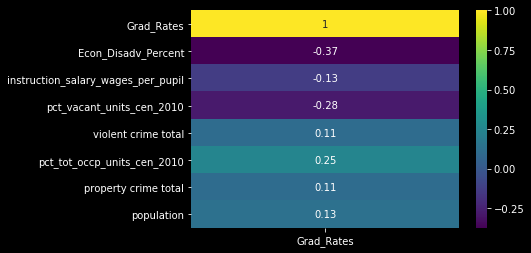

In [26]:
sns.heatmap(sig_feat.corr()[['Grad_Rates']], annot=True, cmap='viridis')

In [27]:
# rural areas have low crime compared to populated areas
# as income decreases grad rate increases

C:\Users\Mark\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


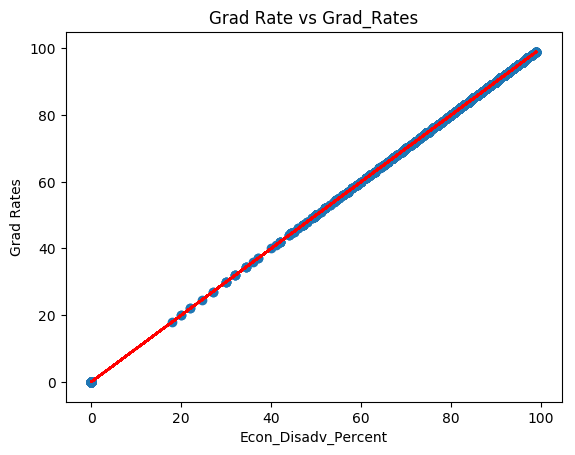

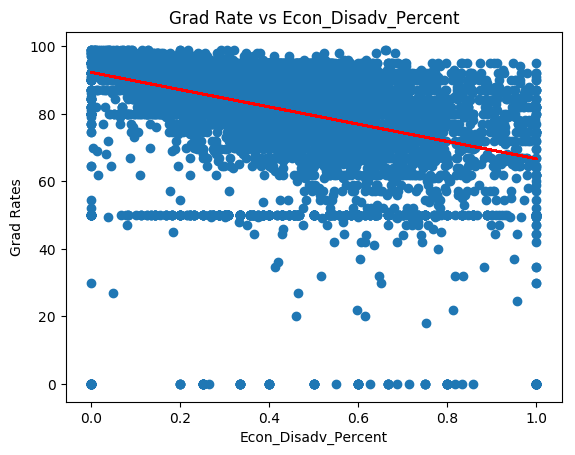

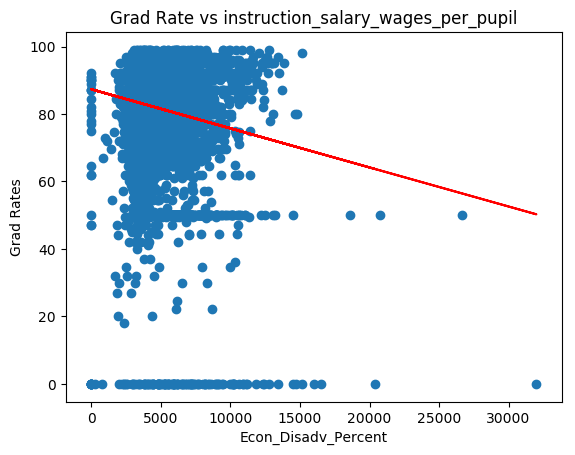

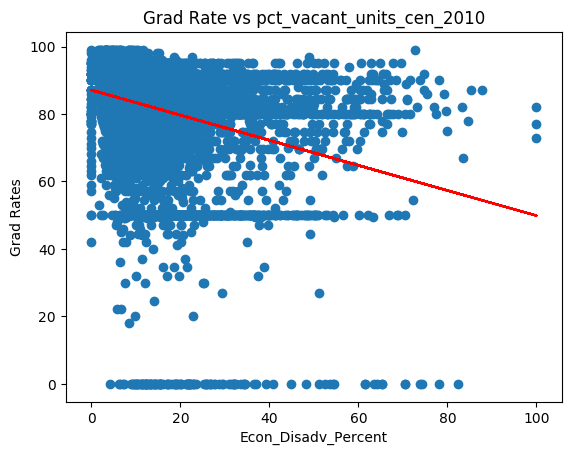

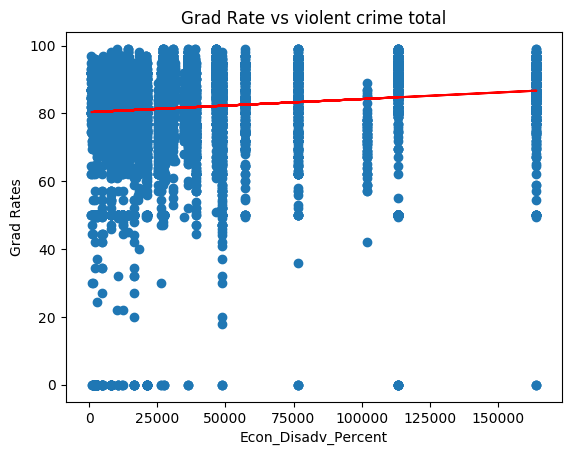

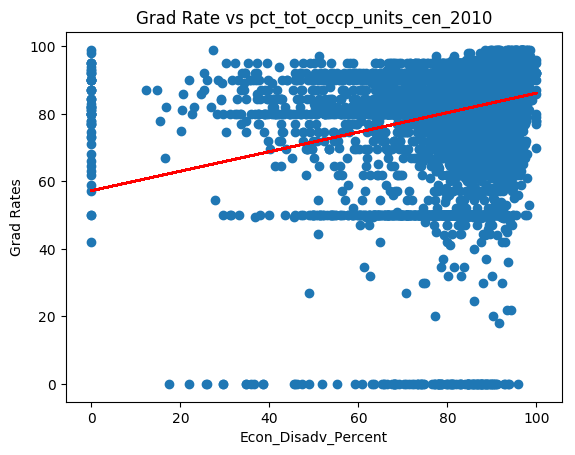

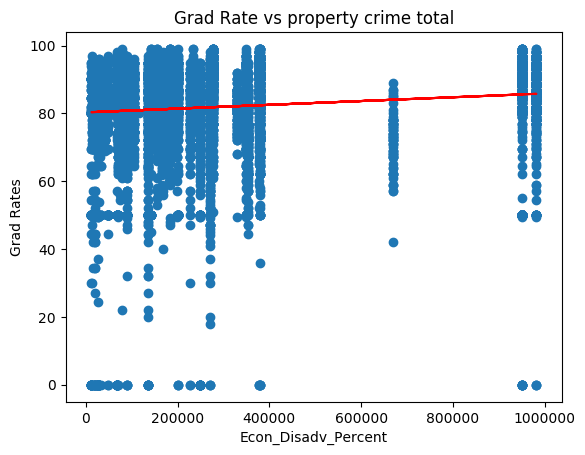

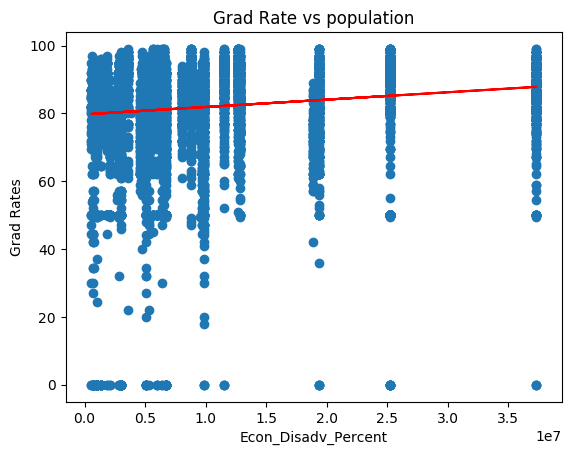

In [28]:
sig_feat_list = ['Grad_Rates', 'Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'pct_vacant_units_cen_2010', 'violent crime total',
               'pct_tot_occp_units_cen_2010', 'property crime total', 'population']

for i in sig_feat_list:
    plt.style.use('default')
    
    x = sig_feat[i]
    y = sig_feat['Grad_Rates']

    fig, ax = plt.subplots()
    reg_line = np.polyfit(x, y, deg=1)
    ax.plot(x, reg_line[0] * x + reg_line[1], color='red')
    ax.scatter(x, y)

    plt.title(f'Grad Rate vs {i}')
    plt.xlabel('Econ_Disadv_Percent')
    plt.ylabel('Grad Rates')
    
    fig.show()

## Model by State

In [188]:
df = df[df['stnam'] == 'CALIFORNIA']

In [189]:
df.columns[:20]

Index(['leaid11', 'stnam', 'fipst', 'leanm11', 'Class_Size', 'Grad_Rates',
       'percentage', 'state', 'county', 'tract.code', 'school.district',
       'district.id', 'gidtr', 'state.1', 'state_name', 'county.1',
       'county_name', 'tract', 'flag', 'num_bgs_in_tract'],
      dtype='object')

In [190]:
X = df.drop(df.columns[:20], axis=1)
y = df['Grad_Rates']
X = X.fillna(0)
y = y.fillna(0)

In [191]:
# model

In [192]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, verbose=1, random_state=101)
rf.fit(X, y)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=101, verbose=1, warm_start=False)

In [193]:
rf_features_df = pd.DataFrame()
rf_features_df['importances'] = rf.feature_importances_
rf_features_df['features'] = X.columns

In [194]:
rf_features_df.sort_values('importances', ascending=False).head(10)

,importances,features
356,0.201283,instruction_salary_wages_per_pupil
355,0.180047,Econ_Disadv_Percent
0,0.049994,land_area
230,0.022619,pct_nh_aian_alone_cen_2010
296,0.018034,pct_not_mrdcple_hhd_acsmoe_08_12
299,0.016506,pct_female_no_hb_acsmoe_08_12
42,0.014457,nh_blk_alone_acs_08_12
227,0.013834,pct_nh_blk_alone_cen_2010
231,0.009377,pct_nh_aian_alone_acs_08_12
314,0.007984,pct_rel_under_6_acsmoe_08_12


In [195]:
# adjusting the features

In [196]:
adjust_feat = ['Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'pct_vacant_units_cen_2010', 'violent crime total', 'pct_tot_occp_units_cen_2010', 'property crime total', 'population']

In [217]:
adjustments = df[df['leanm11'] == 'Cuyama Joint Unified'].copy()

In [218]:
adjustments[adjust_feat]

,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,pct_vacant_units_cen_2010,violent crime total,pct_tot_occp_units_cen_2010,property crime total,population
529,1.0,4363.0,40.29,164133,59.71,981939,37338198


In [219]:
adjustments.set_value(index=529 ,col='Econ_Disadv_Percent', value=3)

,leaid11,stnam,fipst,leanm11,Class_Size,Grad_Rates,percentage,state,county,tract.code,...,pct_census_uaa_cen_2010,pct_mailback_count_cen_2010,pct_frst_frms_cen_2010,pct_rplcmnt_frms_cen_2010,pct_bilq_mailout_count_cen_2010,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,population,violent crime total,property crime total
529,600009,CALIFORNIA,6,Cuyama Joint Unified,7,50.0,36.725997,6,111,100,...,0.0,50.33,34.75,0.0,0.0,3.0,4363.0,37338198,164133,981939


In [220]:
adjustments[adjust_feat]

,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,pct_vacant_units_cen_2010,violent crime total,pct_tot_occp_units_cen_2010,property crime total,population
529,3.0,4363.0,40.29,164133,59.71,981939,37338198


In [223]:
adjust_feat = ['Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'pct_vacant_units_cen_2010', 'violent crime total', 'pct_tot_occp_units_cen_2010', 'property crime total', 'population']
adj_values = [None, 2, 3, 4, 5, 6, 7]
adj_index = adjustments.index[0]
for i in adjust_feat:
    adjustments.set_value(index=adj_index ,col=adjust_feat, value=adj_values)

C:\Users\Mark\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [224]:
adjustments[adjust_feat]

,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,pct_vacant_units_cen_2010,violent crime total,pct_tot_occp_units_cen_2010,property crime total,population
529,NaN,2.0,3.0,4,5.0,6,7


In [203]:
# predicting based on adjusted features

In [204]:
school_to_predict = adjustments.drop(adjustments.columns[:20], axis=1)
school_to_predict = school_to_predict.fillna(0)

In [205]:
rf.predict(school_to_predict)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([ 61.63])

In [206]:
adjustments['Grad_Rates']

529    50.0
Name: Grad_Rates, dtype: float64

In [ ]:
# make it a function

In [364]:
def current_rates(state='California', school='Cuyama Joint Unified', df=df):
    """Find your existing rates and correlated values"""
    state_name = state.upper()
    df = df[df['stnam'] == state_name]
    
    adjustments = df[df['leanm11'] == school].copy()
    adjust_feat = ['leanm11', 'Grad_Rates', 'Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'violent crime total', 'property crime total']
    return adjustments[adjust_feat]

In [452]:
def improvements(state='California', school='Cuyama Joint Unified', disadv_pct=1, salary=2, violent_crime=3, property_crime=4, df=df):
    """Find your new graduation rate based on changes to correlated values"""
#     Select the state name for the school
    state_name = state.upper()
    df = df[df['stnam'] == state_name]
    
#     Create a model for that state
    X = df.drop(df.columns[:20], axis=1)
    y = df['Grad_Rates']
    X = X.fillna(0)
    y = y.fillna(0)
    
    rf = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, random_state=101)
    rf.fit(X, y)
#     scores = cross_val_score(rf,X,y, n_jobs=-1)
    
#     Create a DF for the school adjustments
    adjustments = df[df['leanm11'] == school].copy()
    adjustments = adjustments.drop(adjustments.columns[:20], axis=1)
    adjustments = adjustments.fillna(0)

#     Adjust features
    adjust_feat = ['Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'violent crime total', 'property crime total']
    adj_values = [disadv_pct, salary, violent_crime, property_crime]
    adj_index = adjustments.index[0]
    for i in adjust_feat:
        adjustments.set_value(index=adj_index ,col=adjust_feat, value=adj_values)

#     Make predictions from adjustments    
    new_grad_rate = round(rf.predict(adjustments)[0])
    old_grad_rate = df[df['leanm11'] == school]['Grad_Rates'].iloc[0]   
    
    return print(f'\nYour new graduation rate is {new_grad_rate}% \nYour old graduation rate was {old_grad_rate}%')

In [450]:
current_rates('california', 'Compton Unified')

,leanm11,Grad_Rates,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,violent crime total,property crime total
648,Compton Unified,57.0,0.844272,3743.0,164133,981939


In [453]:
improvements('california', 'Compton Unified', disadv_pct=0.144272, salary=3743, violent_crime=164133, property_crime=981939)


Your new graduation rate is 93.0% 
Your old graduation rate was 57.0%


In [454]:
df

,leaid11,stnam,fipst,leanm11,Class_Size,Grad_Rates,percentage,state,county,tract.code,...,pct_census_uaa_cen_2010,pct_mailback_count_cen_2010,pct_frst_frms_cen_2010,pct_rplcmnt_frms_cen_2010,pct_bilq_mailout_count_cen_2010,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,population,violent crime total,property crime total
0,100005,ALABAMA,1,Albertville City,268,83.0,89.915474,1,95,30903,...,10.39,87.13,55.74,7.40,0.0,0.399254,3035.0,4785401,18363,168828
1,100006,ALABAMA,1,Marshall County,424,79.0,100.000000,1,95,31000,...,17.02,79.45,56.31,6.96,0.0,0.589623,3156.0,4785401,18363,168828
2,100007,ALABAMA,1,Hoover City,1042,91.0,99.903457,1,73,14412,...,2.98,95.06,81.77,0.00,0.0,0.207294,4147.0,4785401,18363,168828
3,100008,ALABAMA,1,Madison City,836,91.0,100.000000,1,89,11021,...,6.99,88.63,58.64,8.42,0.0,0.194976,3296.0,4785401,18363,168828
4,100011,ALABAMA,1,Leeds City,117,72.0,100.000000,1,73,11002,...,17.87,78.31,53.11,7.73,0.0,0.709402,3036.0,4785401,18363,168828
5,100012,ALABAMA,1,Boaz City,155,92.0,71.163668,1,95,31200,...,9.33,88.33,67.38,0.05,0.0,0.438710,3286.0,4785401,18363,168828
6,100013,ALABAMA,1,Trussville City,300,93.0,80.581052,1,73,11108,...,3.84,94.52,77.01,0.00,0.0,0.150000,3359.0,4785401,18363,168828
7,100030,ALABAMA,1,Alexander City,289,78.0,100.000000,1,123,962300,...,13.03,77.33,57.14,5.19,0.0,0.480969,3420.0,4785401,18363,168828
8,100060,ALABAMA,1,Andalusia City,109,77.0,64.091173,1,39,962100,...,23.40,70.62,47.11,5.56,0.0,0.477064,3192.0,4785401,18363,168828
9,100090,ALABAMA,1,Anniston City,207,65.0,100.000000,1,15,200,...,16.73,77.80,54.39,7.16,0.0,0.874396,3792.0,4785401,18363,168828
